In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import host_subplot
import pandas as pd
from sklearn.base import clone
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score as ARI
from sklearn.metrics import rand_score as RI
from tqdm import tqdm  # for timing loops
from joblib import Parallel, delayed  # because these loops are taking forever

from graspologic.embed import CovariateAssistedEmbedding as CASE
from graspologic.embed import LaplacianSpectralEmbed as LSE
from graspologic.simulations import sbm
from graspologic.plot import heatmap, pairplot
from graspologic.utils import remap_labels

import sys


np.set_printoptions(threshold=sys.maxsize)
np.random.seed(42)



In [2]:
def gen_sbm(p, q, assortative=True, N=1500):
    if not assortative:
        p, q = q, p

    n = N // 3
    B = np.full((3, 3), q)
    B[np.diag_indices_from(B)] = p
    A = sbm([n, n, n], B, return_labels=True)

    return A


def gen_covariates(labels, m1=0.8, m2=0.2, agreement=1, d=3):
    """
    n x 3 matrix of covariates.
    just using the guys function from last year for this,
    since I went through it and it seemed like it worked fine.
    """
    N = len(labels)
    d = 3
    B = np.full((d, d), m2)
    B[np.diag_indices_from(B)] = m1
    base = np.eye(d)
    membership = np.zeros((N, d))
    n_misassign = 0
    for i in range(0, N):
        assign = bool(np.random.binomial(1, agreement))
        if assign:
            membership[i, :] = base[labels[i], :]
        else:
            membership[i, :] = base[(labels[i] + 1) % (max(labels) + 1), :]
            n_misassign += 1

    probs = membership @ B

    covariates = np.zeros(probs.shape)
    for i in range(N):
        for j in range(d):
            covariates[i, j] = np.random.binomial(1, probs[i, j])

    return covariates


# probs


def get_misclustering(A, model, labels, covariates=None) -> float:
    if covariates is None:
        Xhat = model.fit_transform(A)
    else:
        Xhat = model.fit_transform(A, covariates=covariates)

    kmeans = KMeans(n_clusters=3, n_jobs=-1)
    labels_ = kmeans.fit_predict(Xhat)

    # to account for nonidentifiability
    labels_ = remap_labels(labels, labels_)
    misclustering = np.count_nonzero(labels - labels_) / len(labels)

    return misclustering


def trial(p=0.03, q=0.016, m1=0.8, m2=0.2, agreement=1, assort=True, algs=[]) -> dict:
    """
    Return misclustering rates for all models under particular assumptions.

    """

    # debugging
    print(f"p: {p}, q: {q}")
    print(f"m1: {m1}, m2: {m2}")
    print(f"agreement: {agreement}")
    print(f"Assortative: {assort}")
    print(f"algorithms: {algs}")

    # set up models
    n_components = 3
    n_subtrials = 16
    N = 1500
    print(f"N={N}")
    print(f"n_subtrials: {n_subtrials}")
    # assrttv_model = CASE(embedding_alg="assortative", n_components=n_components)
    assrttv_model = CASE(
        embedding_alg="assortative", n_components=n_components, tuning_runs=20
    )
    non_assrttv_model = CASE(
        embedding_alg="non-assortative", n_components=n_components, tuning_runs=20
    )
    cca_model = CASE(embedding_alg="cca", n_components=n_components)
    reg_LSE_model = LSE(form="R-DAD", n_components=n_components, algorithm="full")
    cov_LSE_model = clone(reg_LSE_model)

    # collect models
    casc_models = {
        "assortative": assrttv_model,
        "non_assortative": non_assrttv_model,
        "CCA": cca_model,
        "LSE": reg_LSE_model,
        "COV": cov_LSE_model,
    }

    # for testing purposes
    casc_models = {name: casc_models[name] for name in algs}
    print(f"algorithms: {casc_models.keys()}")

    # fit, cluster, get misclustering rates

    def minitrials():
        misclusterings = {}
        A, labels = gen_sbm(p, q, assortative=assort, N=N)
        X = gen_covariates(labels, m1=m1, m2=m2, agreement=agreement)
        for name, model in casc_models.items():
            if name in {"assortative", "non_assortative", "CCA"}:
                misclustering = get_misclustering(A, model, labels, covariates=X)
            elif name == "LSE":
                misclustering = get_misclustering(A, model, labels)
            elif name == "COV":
                misclustering = get_misclustering(X @ X.T, model, labels)

            misclusterings[name] = misclustering
        return misclusterings

    minitrials_ = (delayed(minitrials)() for _ in range(n_subtrials))
    minitrial_results = Parallel(n_jobs=-1, verbose=50)(minitrials_)
    trial_results = {name: [] for name in algs}
    for outcome in minitrial_results:
        for name, misclustering in outcome.items():
            trial_results[name].append(misclustering)

        # A, labels = gen_sbm(p, q, assortative=assort, N=N)
        # X = gen_covariates(labels, m1=m1, m2=m2, agreement=agreement)  # TODO
        # for name, model in casc_models.items():
        #     if name in {"assortative", "non_assortative", "CCA"}:
        #         misclustering = get_misclustering(A, model, labels, covariates=X)
        #     elif name == "LSE":
        #         misclustering = get_misclustering(A, model, labels)
        #     elif name == "COV":
        #         misclustering = get_misclustering(X @ X.T, model, labels)

        # misclusterings[name].append(misclustering)

    # return misclustering rates
    print(f"\nmisclusterings: {trial_results}\n")
    return {k: np.mean(v) for k, v in trial_results.items()}


def membership_trials(
    assortative=True,
    algs=["LSE", "COV", "CCA", "assortative", "non_assortative"],
):
    # algs = ["non_assortative"]
    num_trials = 7
    agreements = np.linspace(0.4, 1, num=num_trials)
    results = np.zeros((num_trials, len(algs) + 1))
    results[:, 0] = agreements
    for i, agreement in enumerate(agreements):
        misclusterings = trial(agreement=agreement, assort=assortative, algs=algs)
        for j, name in enumerate(misclusterings.keys()):
            j += 1  # to account for the xvals column
            results[i, j] = misclusterings[name]
    columns = ["xvals"] + list(misclusterings.keys())
    results = pd.DataFrame(data=results, columns=columns)
    print(f"{results=}")
    return results


def trials(
    p=0.03,
    q=0.015,
    m1=0.8,
    m2=0.2,
    trial_type="",
    assortative=True,
    algs=["LSE", "COV", "CCA", "assortative", "non_assortative"],
):
    """
    vary within-minus between-block probability (p-q)
    """
    num_trials = 7
    # algs = ["LSE", "COV", "CCA"]
    # algs = ["assortative", "non_assortative"]
    # algs = ["COV", "CCA"]

    # set trial parameters
    if trial_type == "probability":
        max_diff = 0.025
        x, y = p, q
    elif trial_type == "covariate":
        max_diff = 0.6
        x, y = m1, m2
    else:
        raise ValueError("need trial_type")

    # generate test space
    xs = np.full(num_trials, y)  # q's
    xvals = np.linspace(0, max_diff, num=num_trials)
    ys = xs + xvals  # p's
    probs = np.c_[xs, ys]
    print(f"\ndiffs: {xvals}")
    print(f"\ntest space: \n{probs}")

    # trials
    results = np.zeros((num_trials, len(algs) + 1))
    results[:, 0] = xvals
    for i, (x, y) in tqdm(enumerate(probs)):
        # for i, (x, y) in enumerate(probs):
        if trial_type == "probability":
            misclusterings = trial(p=y, q=x, assort=assortative, algs=algs)
        elif trial_type == "covariate":
            misclusterings = trial(m1=y, m2=x, assort=assortative, algs=algs)
        for j, name in enumerate(misclusterings.keys()):
            j += 1  # to account for the xvals column
            results[i, j] = misclusterings[name]

    columns = ["xvals"] + list(misclusterings.keys())
    results = pd.DataFrame(data=results, columns=columns)
    print("results:")
    print(results)
    return results


def plot_results(results, ax=None, xlabel="", title=""):
    if ax is None:
        ax = plt.gca()

    linetypes = {
        "assortative": "k--",
        "non_assortative": "k-",
        "CCA": "k:",
        "LSE": "k-.",
    }

    X = results.iloc[:, 0].values
    results_ = results.drop("xvals", axis=1)
    print(results_)
    for name in results_.columns:
        # if name in {"assortative", "non_assortative"}:
        #     continue
        if name == "COV":
            # custom linetype to get long dashes
            (line,) = ax.plot(X, results_["COV"], "k", label=name)
            line.set_dashes([15, 5])
        else:
            (line,) = ax.plot(X, results_[name], linetypes[name], label=name)

    ax.set(
        xlabel=xlabel, ylabel="Average misclustering rate", title=title, ylim=(0, 0.7)
    )

    fig = plt.gcf()
    return line

3333333333333, 0.5386666666666666, 0.52, 0.53, 0.5533333333333333, 0.508, 0.5493333333333333, 0.5113333333333333, 0.544, 0.49666666666666665, 0.5346666666666666, 0.5066666666666667, 0.5246666666666666, 0.5026666666666667, 0.512], 'CCA': [0.5793333333333334, 0.5126666666666667, 0.49066666666666664, 0.45466666666666666, 0.5, 0.47, 0.49466666666666664, 0.5366666666666666, 0.4806666666666667, 0.5073333333333333, 0.46266666666666667, 0.5493333333333333, 0.4746666666666667, 0.554, 0.586, 0.5306666666666666], 'assortative': [0.5526666666666666, 0.5233333333333333, 0.514, 0.5186666666666667, 0.5126666666666667, 0.5713333333333334, 0.5606666666666666, 0.5666666666666667, 0.5413333333333333, 0.5486666666666666, 0.5333333333333333, 0.5186666666666667, 0.554, 0.49533333333333335, 0.5493333333333333, 0.504], 'non_assortative': [0.5526666666666666, 0.5226666666666666, 0.5573333333333333, 0.5186666666666667, 0.5586666666666666, 0.5713333333333334, 0.494, 0.5086666666666667, 0.5386666666666666, 0.488,

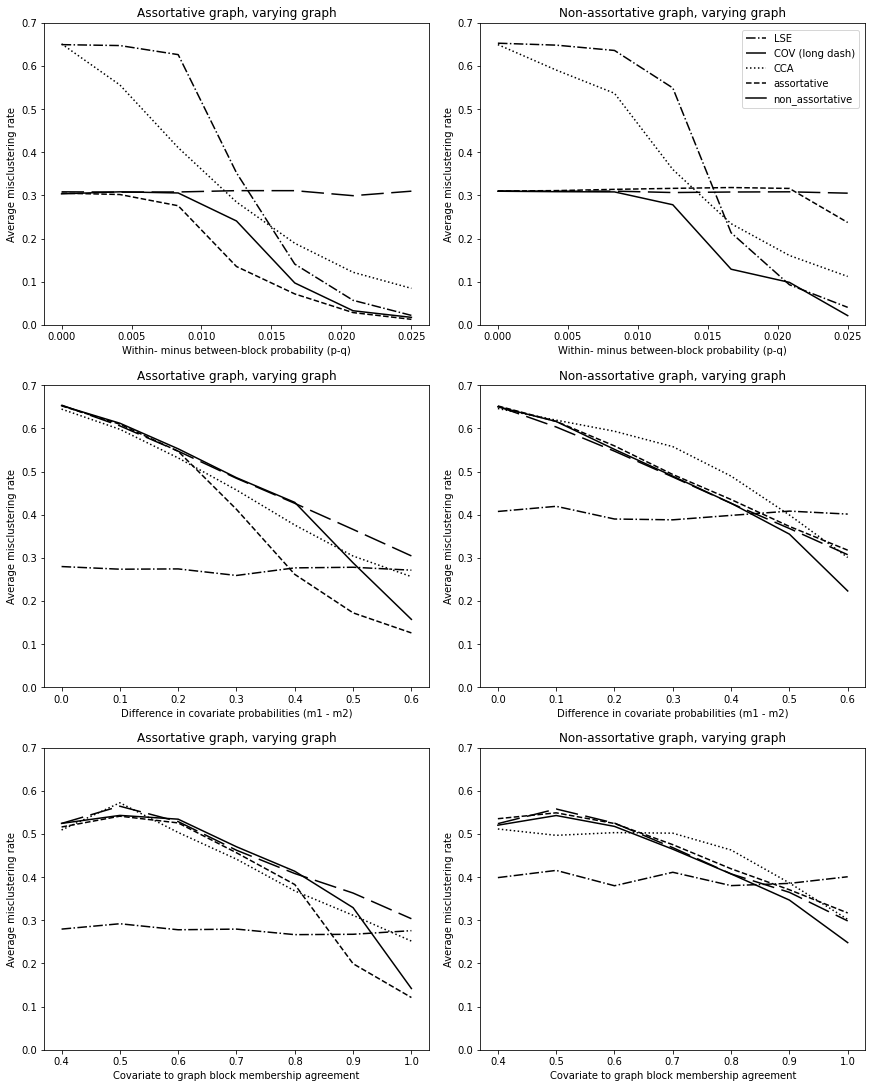

In [2]:
# make figure
fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(12, 15), constrained_layout=True)
plt.rcParams["xtick.top"] = True
plt.rcParams["xtick.direction"] = "in"
plt.rcParams["ytick.direction"] = "in"
plt.rcParams["ytick.right"] = True
assortative_title = "Assortative graph, varying graph"
non_assortative_title = "Non-assortative graph, varying graph"

# plot probability trials
#  assortative
xlabel = "Within- minus between-block probability (p-q)"
assortative_prob = trials(trial_type="probability", assortative=True)
plot_results(assortative_prob, ax=axs[0, 0], xlabel=xlabel, title=assortative_title)
plt.savefig("../figs/figure1_paper.png", bbx_inches="tight")

# non-assortative
non_assortative_prob = trials(trial_type="probability", assortative=False)
plot_results(
    non_assortative_prob, ax=axs[0, 1], xlabel=xlabel, title=non_assortative_title
)
plt.savefig("../figs/figure1_paper.png", bbx_inches="tight")

# # plot covariate trials
xlabel = "Difference in covariate probabilities (m1 - m2)"
#  assortative
assortative_cov = trials(trial_type="covariate", assortative=True)
plot_results(assortative_cov, ax=axs[1, 0], xlabel=xlabel, title=assortative_title)
plt.savefig("../figs/figure1_paper.png", bbx_inches="tight")

#  non-assortative
non_assortative_cov = trials(trial_type="covariate", assortative=False)
plot_results(
    non_assortative_cov, ax=axs[1, 1], xlabel=xlabel, title=non_assortative_title
)
plt.savefig("../figs/figure1_paper.png", bbx_inches="tight")

# plot membership trials
# assortative
xlabel = "Covariate to graph block membership agreement"
membership_prob = membership_trials(assortative=True)
plot_results(membership_prob, ax=axs[2, 0], xlabel=xlabel, title=assortative_title)
plt.savefig("../figs/figure1_paper.png", bbx_inches="tight")

# non-assortative
membership_nonassort = membership_trials(assortative=False)
plot_results(
    membership_nonassort, ax=axs[2, 1], xlabel=xlabel, title=non_assortative_title
)


# figure legend
handles, labels = axs[0, 0].get_legend_handles_labels()
labels = [i if i != "COV" else "COV (long dash)" for i in labels]
fig.legend(handles, labels, loc=(0.85, 0.9))

plt.savefig("../figs/figure1_paper.png", bbx_inches="tight")